In [25]:
import collections
from configparser import Interpolation
import torchvision
import torch
import torchvision.transforms.functional as F
from torchvision.transforms.functional import InterpolationMode
import random 
import numbers
import numpy as np
from PIL import Image

from collections.abc import Sequence

class ExtCompose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, lbl):
        for t in self.transforms:
            img, lbl = t(img, lbl)
        return img, lbl

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string

class ExtToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self, normalize=True, target_type='uint8', is_binary=True):
        self.normalize = normalize
        self.target_type = target_type
        self.is_binary = is_binary
    def __call__(self, pic, lbl):
        """
        Note that labels will not be normalized to [0, 1].
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
            lbl (PIL Image or numpy.ndarray): Label to be converted to tensor. 
        Returns:
            Tensor: Converted image and label
        """
        if self.is_binary:
            tar = np.zeros((lbl.size[1], lbl.size[0]), dtype=self.target_type)
            tar[np.where(np.array(lbl) > 0)] = 1
            #lbl = (np.array( lbl, dtype=self.target_type) / 255) + 1.0 - 1/255
            #lbl = lbl.astype('long')
            return F.to_tensor(pic), torch.from_numpy(tar)
        if self.normalize:
            return F.to_tensor(pic), torch.from_numpy( np.array( lbl, dtype=self.target_type) )
        else:
            return torch.from_numpy( np.array( pic, dtype=np.float32).transpose(2, 0, 1) ), torch.from_numpy( np.array( lbl, dtype=self.target_type) )

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ExtNormalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor, lbl):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
            tensor (Tensor): Tensor of label. A dummy input for ExtCompose
        Returns:
            Tensor: Normalized Tensor image.
            Tensor: Unchanged Tensor label
        """
        return F.normalize(tensor, self.mean, self.std), lbl

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

from torchvision.transforms.functional import normalize

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)

In [2]:
import os
import numpy as np
from PIL import Image
from PIL import ImageOps
from matplotlib import pyplot as plt

(512, 512)
(512, 512)


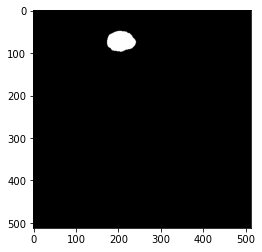

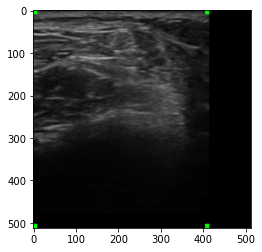

(512, 512)


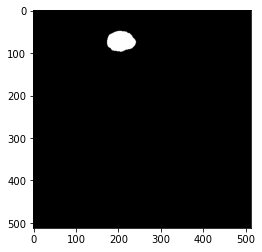

In [30]:
pth = '/home/dongik/datasets/cpn/Images/'
#pth = '/DATA/dongik/datasets/CPN_all/Images/'

transform = ExtCompose([
        ExtToTensor(),
        ExtNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

for fname in os.listdir(pth):
    im = Image.open(os.path.join(pth, fname)).convert('RGB')
    mask = Image.open(os.path.join('/home/dongik/datasets/cpn/Masks', fname)).convert('L')
    print(mask.size)
    print(np.array(mask).shape)
    plt.imshow(np.array(mask), cmap='gray')
    plt.show()
    im, ma = transform(im, mask)

    plt.imshow((denorm(im.numpy()) * 255).transpose(1, 2, 0).astype(np.uint8), )
    plt.show()
    plt.imshow(ma.numpy(), cmap='gray')
    print(ma.numpy().shape)
    break